In [4]:
from sklearn.cluster import KMeans
import pandas as pd
import time
import os
from pandas.core.frame import DataFrame
import tushare as ts
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

In [36]:
begin = '2016-04-01'
end = '2016-04-15'

a = pd.read_excel('/Users/liuhuanshuo/Desktop/pool_date_new.xlsx') #读取经过处理的时间文件 
k = 0 
for i in range(327): 
    '转换时间格式'
    a.ix[k,0] = a.ix[k,0].strftime("%Y-%m-%d")
    k = k+1
    
s = list(a['日期']).index(begin) #提取开始时间的索引
p = list(a['日期']).index(end)   #提取结束时间的索引
a.ix[s,2] = 'F' #修改第一天的end为FALSE 这天不卖出
a.ix[p,3] = 'F' #修改最后一天的select为FALSE 这天不计算
t = a[s:p+1].reset_index(drop=True) #计算begin和end之间的交易日
t = t.fillna(0)  #对空值填充0 方便之后处理
jisuanriqi = t[t['select'] == 'T'] #选择计算日期
jisuanriqi = jisuanriqi.reset_index(drop=True)
jisuanriqi

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,日期,buy,end,select
0,2016-04-01,F,F,T
1,2016-04-08,F,T,T


http://www.csindex.com.cn/uploads/file/autofile/closeweight/000300closeweight.xls
        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0 -0.278963 -0.281367 -0.387768 -0.255786 -0.404460 -0.035978   112
1 -0.504186 -0.517178  0.504236  1.606976  2.147279  3.378076     8
2  3.296784  3.314314 -0.412980  1.923354 -0.523160 -0.862332     5
3  9.434572  9.390562 -0.912877 -0.626041 -0.854801 -0.536618     1
4 -0.510276 -0.513671  0.715170 -0.187834  0.611545  0.069769    53
5  0.705382  0.720267 -0.725499 -0.200873 -0.721392 -0.555897    53
6 -0.719139 -0.729500  3.895620 -0.367720  4.980416  0.978915     3
7  1.688393  1.628930 -0.529152  5.482800 -0.330664  2.440535     4
8 -0.398421 -0.399170  2.382221  0.469638  1.699659 -0.362926    14


/anaconda3/lib/python3.6/site-packages/matplotlib/font_manager.py:1320: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


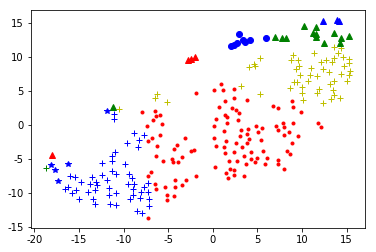

        ma5      ma10    v_ma10  turnover    volume  p_change  类别数目
0  0.994927  1.008099 -0.807472 -0.176303 -0.763181  0.236579    34
1 -0.210554 -0.208387 -0.451249 -0.301606 -0.471391 -0.117916   118
2 -0.469871 -0.479573  2.936041  0.639709  2.897741 -0.591754    11
3  4.649954  4.555228 -0.758337  3.694087 -0.430163 -2.335474     3
4 -0.509326 -0.512790  0.866964  0.885830  2.661197  1.870523     7
5  0.880941  0.854585  0.151257  2.894060  0.101462 -0.503776    10
6  0.000152 -0.003709 -0.588418  1.049694  0.044693  3.815589     5
7  9.180289  9.322274 -0.953468 -0.641494 -0.903816 -0.379410     1
8 -0.527683 -0.530100  0.770397 -0.266944  0.524999 -0.120793    61


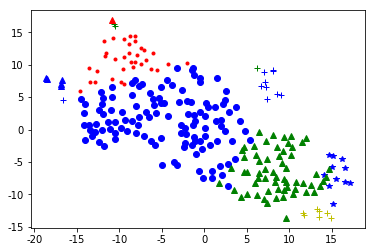

In [37]:
b = ts.get_hs300s()
dd = pd.DataFrame(columns = ['code','date','open','close'])
for o in jisuanriqi['日期']:
    daima = pd.DataFrame(columns = ['code','open','close','ma5','ma10','v_ma10','turnover','volume','p_change'])
    for i in b['code']:
        try:
            s = ts.get_hist_data(i,start=o,end=o)
            s.insert(0,'code',i)
            s = s.loc[:,['code','open','close','ma5','ma10','v_ma10','turnover','volume','p_change']]
            daima = daima.append(s,ignore_index=True)
        except:
            pass
    daima.insert(1,'date',o)
    data = daima.loc[:,['ma5','ma10','v_ma10','turnover','volume','p_change']]
    k = 9 #聚类的类别
    iteration = 500 #聚类最大循环次数
    data = data
    data_zs = 1.0*(data - data.mean())/data.std() #数据标准化
    model = KMeans(n_clusters = k, n_jobs = 9, max_iter = iteration) #分为k类, 并发数9
    model.fit(data_zs) #开始聚类
    #简单打印结果
    r1 = pd.Series(model.labels_).value_counts() #统计各个类别的数目
    r2 = pd.DataFrame(model.cluster_centers_) #找出聚类中心
    r = pd.concat([r2, r1], axis = 1) #横向连接(0是纵向), 得到聚类中心对应的类别下的数目
    r.columns = list(data.columns) + [u'类别数目'] #重命名表头
    print(r)

    #详细输出原始数据及其类别
    r = pd.concat([data, pd.Series(model.labels_, index = data.index)], axis = 1)  #详细输出每个样本对应的类别
    r.columns = list(data.columns) + [u'聚类类别'] #重命名表头
    r



    tsne = TSNE()
    tsne.fit_transform(data_zs) #进行数据降维
    tsne = pd.DataFrame(tsne.embedding_, index = data_zs.index) #转换数据格式
    plt.rcParams['font.sans-serif'] = ['SimHei'] #用来正常显示中文标签
    plt.rcParams['axes.unicode_minus'] = False #用来正常显示负号
    #不同类别用不同颜色和样式绘图
    d = tsne[r[u'聚类类别'] == 0]
    plt.plot(d[0], d[1], 'r.')
    d = tsne[r[u'聚类类别'] == 1]
    plt.plot(d[0], d[1], 'bo')
    d = tsne[r[u'聚类类别'] == 2]
    plt.plot(d[0], d[1], 'b*')
    d = tsne[r[u'聚类类别'] == 3]
    plt.plot(d[0], d[1], 'g+')
    d = tsne[r[u'聚类类别'] == 4]
    plt.plot(d[0], d[1], 'y+')
    d = tsne[r[u'聚类类别'] == 5]
    plt.plot(d[0], d[1], 'b+')
    d = tsne[r[u'聚类类别'] == 6]
    plt.plot(d[0], d[1], 'b^')
    d = tsne[r[u'聚类类别'] == 7]
    plt.plot(d[0], d[1], 'r^')
    d = tsne[r[u'聚类类别'] == 8]
    plt.plot(d[0], d[1], 'g^')
    plt.show()
    
    t= r.loc[:,'聚类类别']
    daima.insert(10,'聚类类别',t)
    cc = daima[(daima.聚类类别 == 7)]
    cc = cc.reset_index(drop=True)
    ee = cc.loc[:,['code','date','open','close']]
    dd = dd.append(ee,ignore_index=True)

In [39]:
dd

,code,date,open,close
0,002027,2016-04-01,30.31,33.95
1,002174,2016-04-01,118.94,122.26
2,002460,2016-04-01,50.97,52.39
3,002601,2016-04-01,57.00,61.50
4,600519,2016-04-08,252.00,249.86
